# 5장. 서포트 벡터 머신

> 5.1. 선형 SVM 분류 \
> 5.2. 비선형 SVM 분류 \
> 5.3. SVM 회귀 \
> 5.4. SVM 이론 \
> 5.5. 쌍대 문제

## 서포트 벡터 머신 (Support Vector Machine)

- **분류**, 회귀, 특이치 탐지에 사용하는 다목적 머신러닝 모델 (지도학습)
- 서포트 벡터 : 클래스 경계에 위치한 샘플로 결정 경계*hyperplane)를 구분하는데 중요
- 마진이 큰 방향으로 학습 -> 라지 마진 분류(Large Margin Classification)

## 설정

In [6]:
import sys

assert sys.version_info >= (3, 7)

In [7]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [9]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 5.1 선형 SVM 분류

그림 5-1. 라지 마진 분류

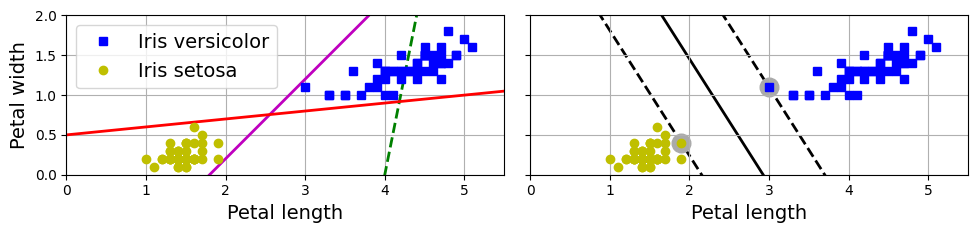

In [10]:
# 추가 코드 - 이 셀은 그림 5-1을 생성하고 저장합니다.

import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=10**9)
svm_clf.fit(X, y)

# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

save_fig("large_margin_classification_plot")
plt.show()

- 4장에서 다루었던 붓꽃 데이터

- 왼쪽 그래프
1. 세 개의 선형 분류기를 이용 (여기서는 임의의 선)
2. 초록 결정경계는 적절한 분류를 못하고 있음
3. 나머지 두 결정경계는 분류를 잘하고 있으나 샘플에 너무 가까움 -> unseen data에 대해 분류를 잘 못할 수도 있음

- 오른쪽 그래프
1. SVM 분류기를 이용
2. 결정경계(실선)가 분류를 하고 있음
3. 각 클래스의 샘플로부터 가능한 멀리 떨어져 있음 (라지 마진 분류)
4. 마진 경계선(점선)에 위치한 샘플을 서포트 벡터라고 부름
5. 마진 밖에 훈련 샘플이 추가되어도 결정 경계에는 영향을 주지 않음

> DMZ 그리기 같은 느낌 \
> 결정경계(hyperplane, 초평면)에서 각 클래스의 서포트 벡터까지의 거리를 마진이라고 함 : 두 거리를 합친 것을 마진이라고 하기도 함 \
> 각 클래스의 마진크기는 같음

> - 일반 선형 분류: 일반적인 선형 분류 모델(예: 로지스틱 회귀)은 데이터를 구분하는 **하나의 결정 경계(직선이나 초평면)**를 설정, 이 결정 경계는 보통 오류를 최소화하는 방향으로 설정 \
> - SVM 분류: SVM은 결정 경계뿐만 아니라, 서포트 벡터라고 불리는 두 클래스의 가장 가까운 샘플들 사이의 최대 마진을 찾는 방식으로 경계를 설정, SVM은 클래스 사이의 거리를 최대화하는 최적의 결정 경계를 찾아내는 데 초점

그림 5-2 특성 스케일에 따른 민감성

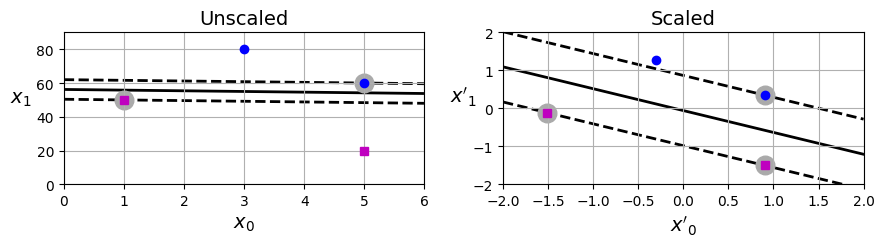

In [11]:
# 추가 코드 - 이 셀은 그림 5-2를 생성하고 저장합니다.

from sklearn.preprocessing import StandardScaler

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()

save_fig("sensitivity_to_feature_scales_plot")
plt.show()

SVM은 특성의 스케일에 민감함
> 샘플 간 거리를 기반으로 동작하기 때문에, 특성의 값이 크면 큰 대로, 작으면 작은 대로 영향을 받아 스케일이 중요해짐.
>> 값이 크면 모델에 더 큰 영향을 주고, 작으면 무시될수도 있음.. 그래서 스케일링이 필요함

### 5.1.1 소프트 마진 분류

그림 5-3 이상치에 민감한 하드 마진

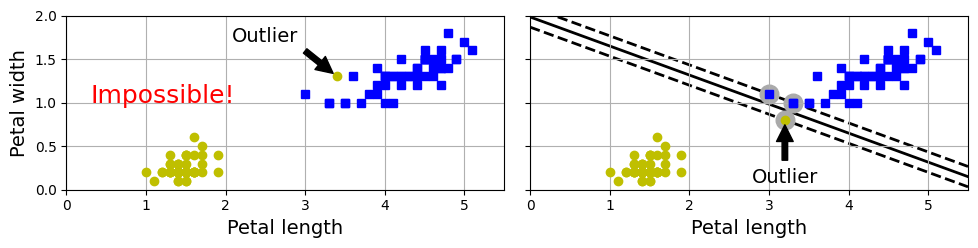

In [12]:
# 추가 코드 - 이 셀은 그림 5-3을 생성하고 저장합니다.

X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

save_fig("sensitivity_to_outliers_plot")
plt.show()

하드 마진 분류
- 모든 샘플이 결정 경계와 마진 바깥쪽에 올바르게 분류됨, 오류가 허용되지 않음
- 데이터가 선형적으로 구분되어야 함
- 이상치에 민감 -> 데이터에 이상치가 있으면 결정 경계가 왜곡될 수 있음
-- 선형분류가 불가능하거나 일반화가 어려움

--> 좀 더 유연한 모델이 필요함

소프트 마진 분류
- 마진 오류를 허용하면서 결정 경계 도로의 폭을 최대로 하는 방향으로 유도
- 마진 오류 : 샘플이 마진 중간이나 반대 클래스쪽에 있는 경우
- `C` : SVM 규제 파라미터
-- C를 줄이면 마진이 커지고 훈련에러 허용을 많이 함 -> underfit 가능
-- C를 늘리면 마진이 줄어들고 훈련에러 허용을 적게 함 -> overfit 가능


In [13]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2) # Iris-Virginica

svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, random_state=42))
svm_clf.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

그림 5.4 넓은 마진(왼쪽) vs. 적은 마진 오류(오른쪽)

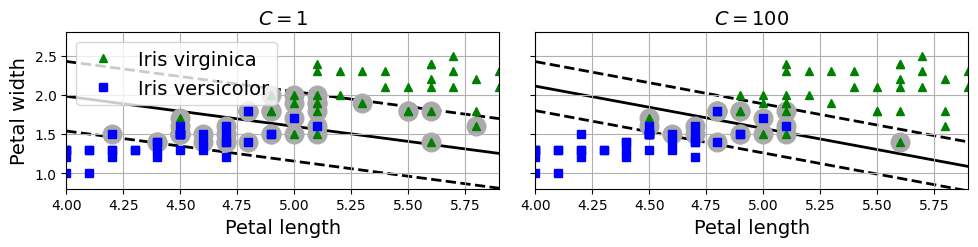

In [14]:
# 추가 코드 - 이 셀은 그림 5-4를 생성하고 저장합니다.

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, dual=True, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, dual=True, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# 스케일링되지 않은 파라미터로 변환
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기(LinearSVC는 이 작업을 자동으로 수행하지 않음)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

save_fig("regularization_plot")
plt.show()

> 위에서는 C=100이 더 일반화가 잘됨

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


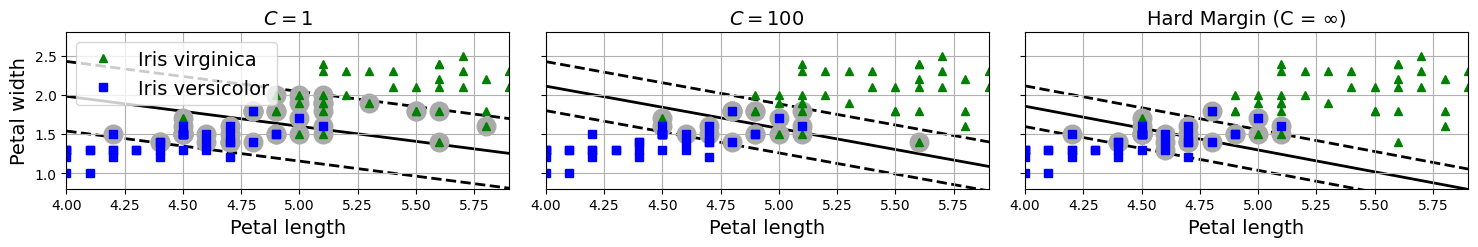

In [15]:
scaler = StandardScaler()

# 소프트 마진 SVM
svm_clf1 = LinearSVC(C=1, max_iter=10_000, dual=True, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, dual=True, random_state=42)

#svm_clf3 = LinearSVC(C=float("Inf"), max_iter=10_000, dual=True, random_state=42)
svm_clf3 = LinearSVC(C=10**9, max_iter=10_000, dual=True, random_state=42)

# 스케일링된 모델로 파이프라인 구성
scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)
scaled_svm_clf3 = make_pipeline(scaler, svm_clf3)

# 모델 학습
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)
scaled_svm_clf3.fit(X, y)

# 스케일링되지 않은 파라미터로 변환
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
b3 = svm_clf3.decision_function([-scaler.mean_ / scaler.scale_])

w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
w3 = svm_clf3.coef_[0] / scaler.scale_

svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf3.intercept_ = np.array([b3])

svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])
svm_clf3.coef_ = np.array([w3])

# 서포트 벡터 찾기(LinearSVC는 이 작업을 자동으로 수행하지 않음)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
support_vectors_idx3 = (t * (X.dot(w3) + b3) < 1).ravel()

svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]
svm_clf3.support_vectors_ = X[support_vectors_idx3]

# 그래프 생성
fig, axes = plt.subplots(ncols=3, figsize=(15, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[2])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf3, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"Hard Margin (C = ∞)")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

save_fig("regularization_plot_with_hard_margin")
plt.show()

In [16]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

In [17]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

> SVM 모델은 샘플과 결정 경계 사이의 거리를 측정함 (양수 또는 음수) \
> - 0이면 결정경계 \
> - 양수이면 해당 클래스에 속함
> - 음수이면 반대방향(다른 클래스)을 의미

LinearSVC는 클래스 확률을 추정하는 predict_proba()를 지원하지 않음
- 빠른 성능과 대규모 데이터 처리에 중점. 확률 추정을 하지 않음.

In [18]:
from sklearn.svm import SVC

svm_clf = SVC(probability=True)
svm_clf.fit(X, y) #y = (iris.target == 2) # Iris-Virginica

probs = svm_clf.predict_proba(X_new)


In [19]:
probs

array([[0.03662846, 0.96337154],
       [0.58824688, 0.41175312]])

> 클래스에 속할 확률 \
> 샘플1 : 96.1% \
> 샘플2 : 39.5%

## 5.2 비선형 SVM 분류

선형적으로 분류할 수 없는 데이터셋을 다루는 방법

그림 5-5 특성을 추가하여 선형적으로 구분되는 데이터셋 만들기

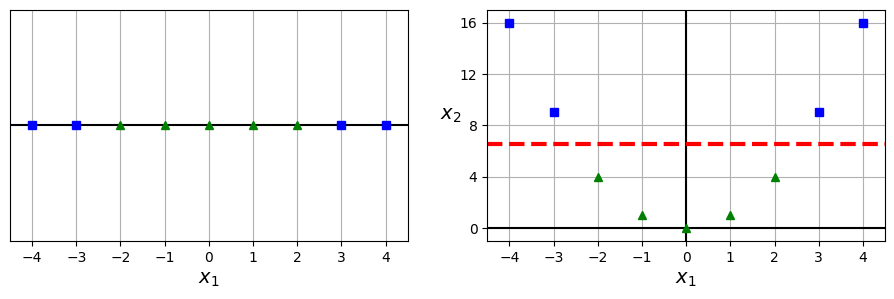

In [20]:
# 추가 코드 - 이 셀은 그림 5-5를 생성하고 저장합니다.

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

다항특성 추가
- 다항 회귀에서 처럼 다항 특성을 추가 --> **차원을 늘려서 선형으로 분류**
- 왼쪽 그래프는 선형분류가 불가능한 데이터
- 오른쪽 그래프는 두번째 특성으로 x <sub>2</sub> = (x<sub>1</sub>) <sup>2</sup> 을 추가하여 2차원 데이터셋을 만듬

In [21]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples = 100, noise = 0.15, random_state = 42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree = 3),
    StandardScaler(),
    LinearSVC(C = 10, max_iter = 10_000, random_state = 42)
)

polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

그림 5-6 다항 특성을 사용한 선형 SVM 분류기

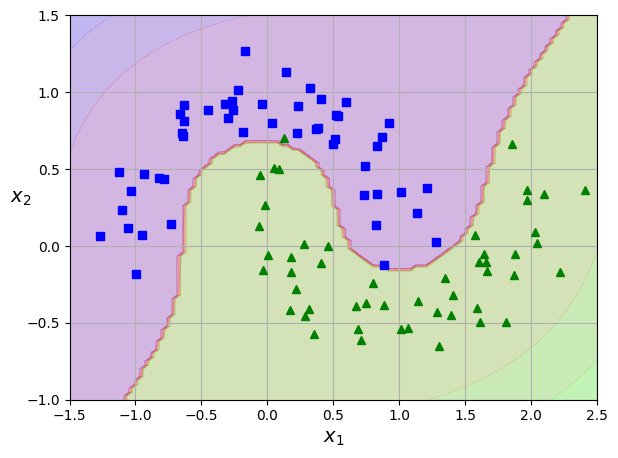

In [22]:
# 추가 코드 - 이 셀은 그림 5-6을 생성하고 저장합니다.

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

moons 데이터를 이용해서 `PolynomialFeatures` 변환기와 `LinearSVC` 연결

### 5.2.1.다항식 커널

- 다항 특성을 추가하는 것은 모델을 느리게 만든다
- **커널 트릭**은 특성을 추가하지 않고, 매우 높은 차수의 다항 특성을 추가한 것과 같은 결과를 얻게 해줌.

3차 다항식 커널
> kernel = "poly" : 다항식커널 \
> degree = 3 : 3차 다항식 \
> coef0 : 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절 \
>> 다항식커널이 내적을 할 때 벡터의 크기가 미치는 영향을 조절 \
>> coef0 = 0 : 벡터의 크기에 많은 영향
>> coef0 > 0 : 벡터의 크기 영향을 줄이고 방향이나 각도 같은 관계를 중요하게 |

> C : 규제 파라미터

In [23]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(), SVC(kernel = "poly", degree = 3, coef0 = 1, C = 5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

그림 5-7 다항식 커널을 사용한 SVM 분류기

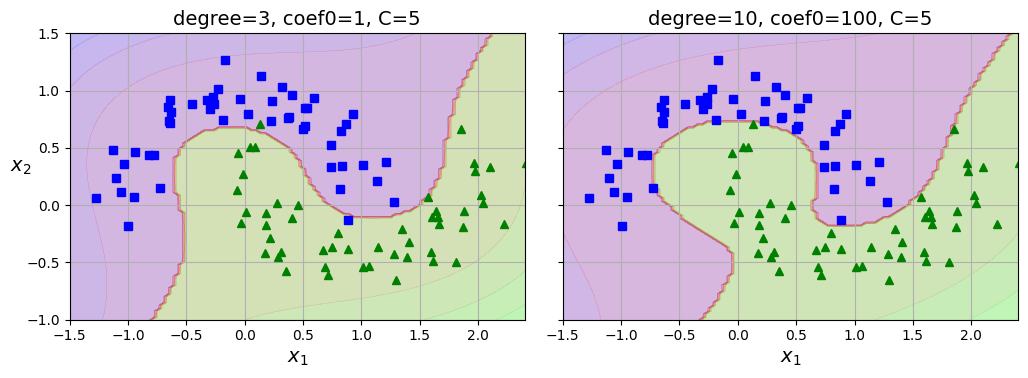

In [24]:
# 추가 코드 - 이 셀은 그림 5-7을 생성하고 저장합니다.

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

다항 커널 모델이 과대 적합이면 차수를 줄여야 하고, 과소 적합이면 차수를 늘려야 한다.

> PolynomialFeatures 3차항 특성을 추가한 그림과 유사

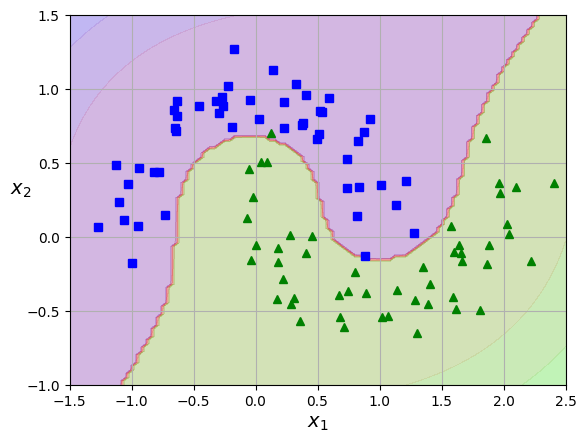

In [25]:
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

#save_fig("moons_polynomial_svc_plot")
plt.show()

### 5.2.2. 유사도 특성

- 비선형특성을 다루는 또 다른 기법 \
- 각 샘플이 특정 기준(랜드마크)와 얼마나 유사한지 계산해서 새로운 특성으로 추가

> 랜드마크는 랜덤하게 선택하거나 전략적으로 선택 \
> 비선형 데이터 분류: 랜드마크를 사용하면 샘플 간의 비선형 관계를 더 잘 포착함.\
> 고차원 변환: 랜드마크와의 유사도를 특성으로 변환하면, 데이터는 고차원 공간으로 변환되며, 이 공간에서는 데이터가 선형적으로 분리될 가능성이 높아짐.\
> 커널 트릭과 유사: 커널 기법을 사용하지 않고도, 랜드마크와 유사도 계산을 통해 비슷한 효과를 얻을 수 있음

가우스 방사 기저 함수(RBF)
- 랜드마크(m)에서 멀어지면 값이 급격히 작아지게 함
- 감마는 얼마나 빨리 0으로 수렴하게 할지 결정. 값이 크면 m에서 멀어질수록 급격히 0으로 수렴 -> 종모양이 좁아지게 됨

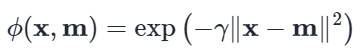

그림 5-8. 가우스 RF를 사용한 유사도 특성

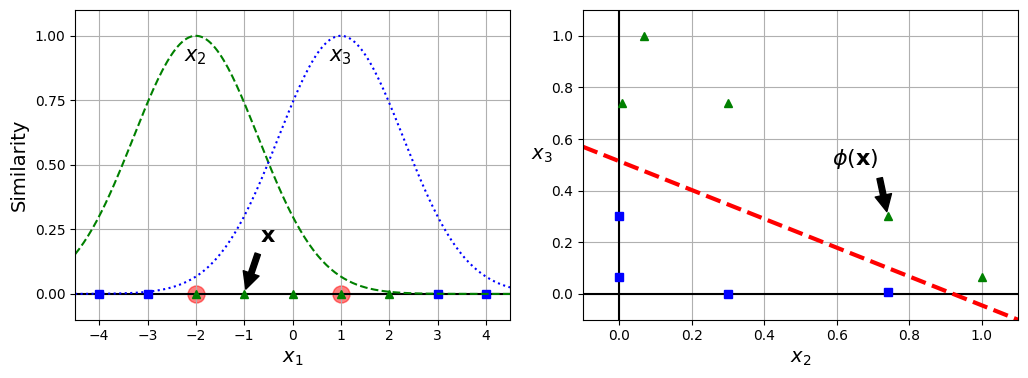

In [26]:
# 추가 코드 - 이 셀은 그림 5-8을 생성하고 저장합니다.

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r'$\mathbf{x}$',
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$  ", rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])

plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

- 두개의 랜드마크 -2, 1을 기준으로 x=-1 샘플의 유사도를 확인하는 그래프
- x2, x3로 변환된 데이터셋으로 선형 분류가 가능해짐

- 랜드마크를 어떻게 설정할까?
- 모든 샘플 위치에 랜드마크를 설정하면 차원이 매우 커져 선형 분류 가능성이 높아짐
-> 특성이 매우 늘어남 (복잡도 높아짐, 과적합 가능성)

In [27]:
import pandas as pd
df_gaussian_rbf = pd.DataFrame({
    "x1": X1D.flatten(),
    "x2 (m: -2)": gaussian_rbf(X1D, -2, gamma),
    "x3 (m: 1)": gaussian_rbf(X1D, 1, gamma)
})

print(df_gaussian_rbf)

    x1  x2 (m: -2)  x3 (m: 1)
0 -4.0    0.301194   0.000553
1 -3.0    0.740818   0.008230
2 -2.0    1.000000   0.067206
3 -1.0    0.740818   0.301194
4  0.0    0.301194   0.740818
5  1.0    0.067206   1.000000
6  2.0    0.008230   0.740818
7  3.0    0.000553   0.301194
8  4.0    0.000020   0.067206


In [28]:
import numpy as np
import pandas as pd

# 임시 데이터
test_X1D = np.array([[-4], [-3], [-1], [0], [2], [3], [4]])

# 모든 샘플을 랜드마크로 설정하여 유사도 계산
test_XK = np.zeros((test_X1D.shape[0], test_X1D.shape[0]))
for i in range(test_X1D.shape[0]):
    test_XK[:, i] = gaussian_rbf(test_X1D, test_X1D[i], gamma)

# 유사도 행렬을 DataFrame으로 변환
test_df_XK = pd.DataFrame(test_XK, columns=[f"Landmark {i+1}" for i in range(test_X1D.shape[0])])

# 유사도 행렬 출력
print(test_df_XK)


     Landmark 1    Landmark 2  Landmark 3  Landmark 4  Landmark 5  \
0  1.000000e+00  7.408182e-01    0.067206    0.008230    0.000020   
1  7.408182e-01  1.000000e+00    0.301194    0.067206    0.000553   
2  6.720551e-02  3.011942e-01    1.000000    0.740818    0.067206   
3  8.229747e-03  6.720551e-02    0.740818    1.000000    0.301194   
4  2.039950e-05  5.530844e-04    0.067206    0.301194    1.000000   
5  4.129249e-07  2.039950e-05    0.008230    0.067206    0.740818   
6  4.587182e-09  4.129249e-07    0.000553    0.008230    0.301194   

     Landmark 6    Landmark 7  
0  4.129249e-07  4.587182e-09  
1  2.039950e-05  4.129249e-07  
2  8.229747e-03  5.530844e-04  
3  6.720551e-02  8.229747e-03  
4  7.408182e-01  3.011942e-01  
5  1.000000e+00  7.408182e-01  
6  7.408182e-01  1.000000e+00  


> N개의 샘플이면 N의 특성이 생기고, N<sup>2</sup> 의 유사도 계산이 필요함

### 5.2.3 가우스 RBF 커널

- 유사도 특성 방식은 추가 특성을 모두 계산하려면 연산 비용이 많이 필요함
-- 특히 데이터 크기가 크면 더 많이 필요하게 됨
- 커널 트릭????? 을 이용해서 비슷한 결과를 얻을 수 있음. -> 가우스 RBF 커널


In [29]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

그림 5-9. RBF 커널을 사용한 SVM 분류기

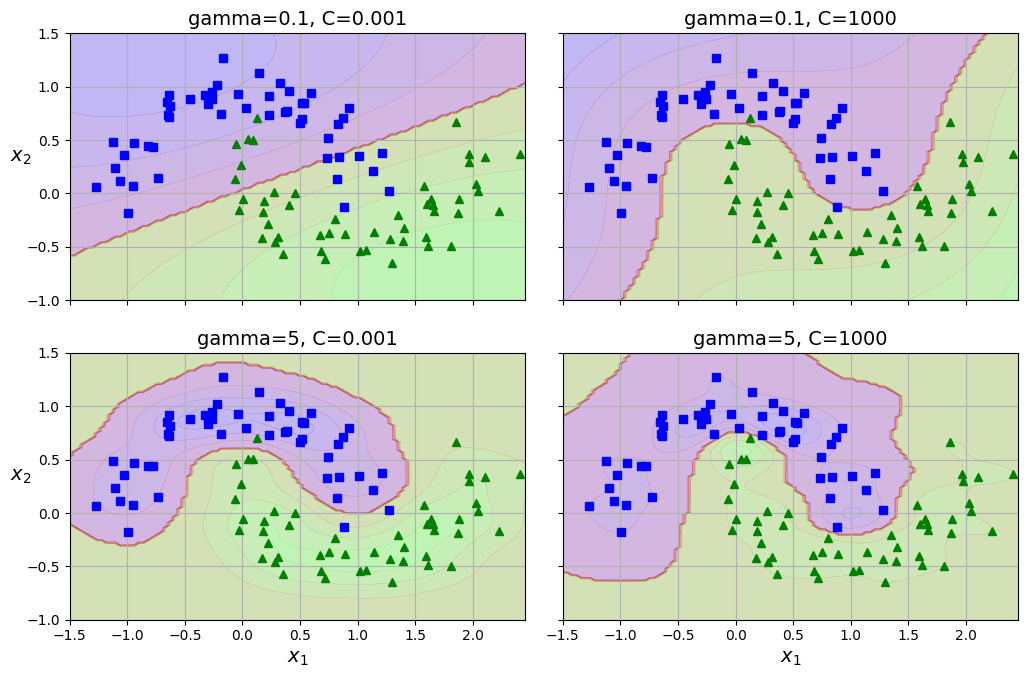

In [30]:
# 추가 코드 - 이 셀은 그림 5-9를 생성하고 저장합니다.

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

- 감마 증가 시키면 -> 종모양 좁아짐 -> 각 샘플의 영향 범위가 작아짐 -> 결정 경계가 불규칙해지면서 각 샘플을 따라 구불구불 휘어짐
- 감자가 작으면 -> 종모양 넓어짐 -> 샘플 넓은 범위에 영향을 주므로 결졍 경계가 부드러워짐

-> 과대적합이면 감마를 감소 시키고, 과소적합이면 증가시켜야 함

- 이외에 다른 커널들은 거의 사용되지 않음
- 문자열커널(string kernerl)이 가끔 텍스트 문서나 DNA 서열 분류 때 사용됨

- 선형 커널을 먼저 시도할 것 (LinearSVC가 SVC(kernel='linear')보다 빠름
- 훈련세트가 너무 크지 않다면 가우스 RBF 커널도 시도하면 좋음
- 리소스가 되면 교차 검증과 하이퍼파라미터 탐색으로 좋은 커널 테스트

### 5.2.4. 계산 복잡도

LinearSVC
- liblinear 라이브러리 사용 (선형 SVM을 위한 최적화된 알고리즘)
-- 커널 트릭 지원 안함
-- 훈련 샘플과 특성수에 선형적으로 늘어남. -> O(mxn) // m: 샘플수, n : 특성수

SVC
- libsvm 라이브러리 사용 (커널 트릭 알고리즘)
-- O(m <sup>2</sup> x n) 또는 O(m <sup>3</sup> x n) : 샘플수가 많아질 수록 느려짐
-- 커널 계산에 의함. + 샘플간 거리 계산

SGDClassifier
- O(mxn)

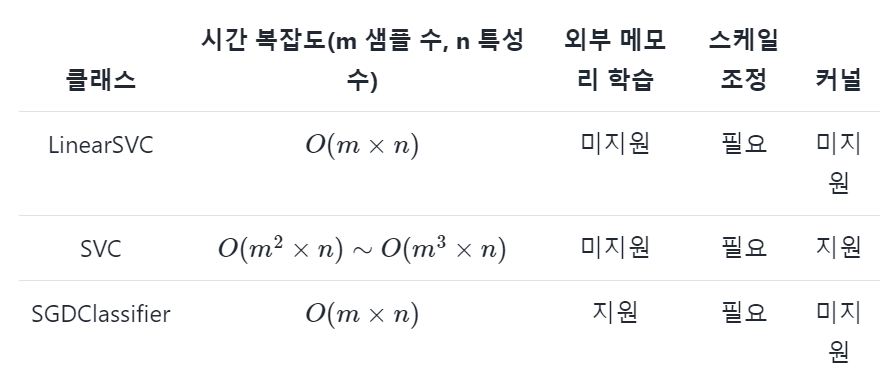

## 5.3 SVM 회귀

SVM을 회귀에도 사용 가능

- 목표 : 지정된 도로 안에 많은 샘플이 들어오록 함
- 마진오류 : 도로 밖의 샘플
- 도로폭 : 하이퍼파라미터 ϵ

In [31]:
from sklearn.svm import LinearSVR

# 추가 코드 - 이 세 줄은 간단한 선형 데이터셋을 생성합니다.
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, dual=True, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(dual=True, epsilon=0.5, random_state=42))])

그림 5-10. SVM 회귀

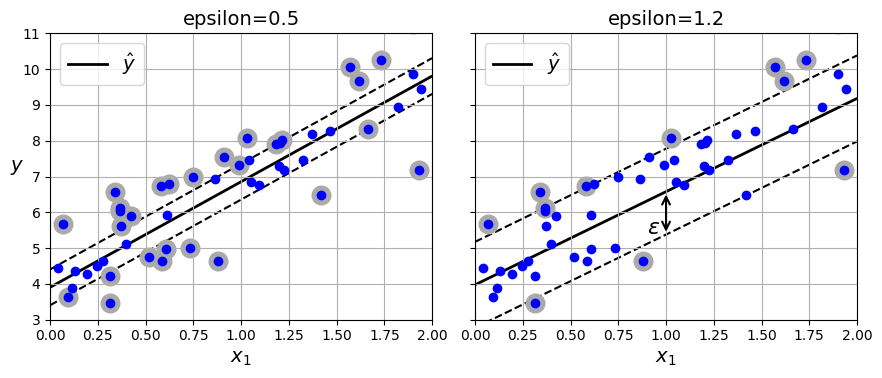

In [32]:
# 추가 코드 - 이 셀은 그림 5-10을 생성하고 저장합니다.

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, dual=True, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
save_fig("svm_regression_plot")
plt.show()

- ϵ이 작으면 도로폭 작아짐 : 서포트벡터(마진 밖에 위치한 샘플)가 늘어나서 모델 규제

> - 마진 안의 데이터: 예측이 충분히 정확하므로, 모델이 그 데이터에 대해 학습하거나 예측을 수정하지 않습니다. 즉, 마진 안에 추가적인 데이터를 더 넣어도 모델이 변화하지 않는다는 의미\
> - 마진 밖의 데이터: 예측 값과 실제 값의 차이가 큰 데이터로, 모델이 학습하고 예측을 조정하는 데 중요한 역할

비선형 회귀

In [33]:
from sklearn.svm import SVR

# 추가 코드 - 이 세 줄은 간단한 2차방정식 데이터셋을 생성합니다.
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

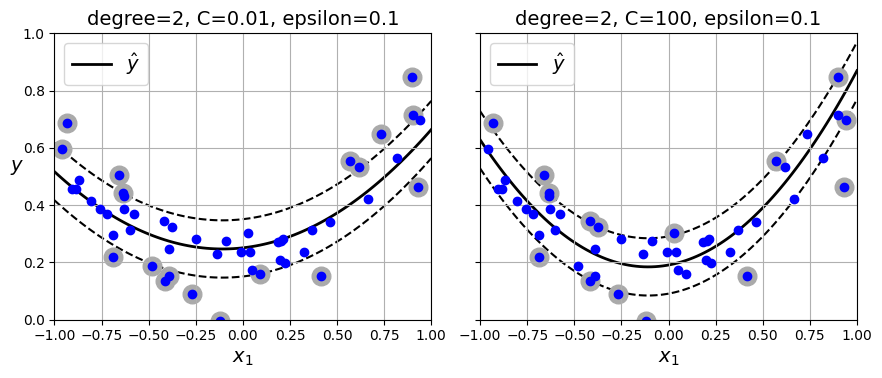

In [34]:
# 추가 코드 - 이 셀은 그림 5-11을 생성하고 저장합니다.

svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

## 5.4 SVM 이론

- 선형 SVM 분류기 모델은 결정함수를 계산해서 새로운 샘플 X의 클래스를 예측
- 결과가 0보다 크면 예측된 클래스, 0보다 작으면 음성 클래스
- 결정경계는 결정함수의 값이 0인 선
- 마진의 가장자리는 결정함수의 값이 +1, -1인 선

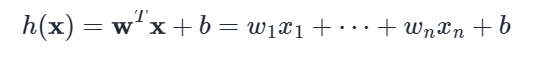

결정함수의 기울기로 w와 마진 크기 확인
- 왼쪽 그래프 가중치 = 1
-- 마진의 경계를 +1, -1이라고 정의해보고,
-- w<sub>1</sub>x<sub>1</sub> = -1 또는 +1 : x<sub>1</sub> = -1, +1
-- 마진의 크기는 2

- 오른쪽 그래프 가중치 = 0.5
-- w<sub>1</sub>x<sub>1</sub> = -1 또는 +1 : x<sub>1</sub> = -2, +2
-- 마진의 크기는 4

b는 마진의 크기에 영향을 주지 않으므로 일단 무시

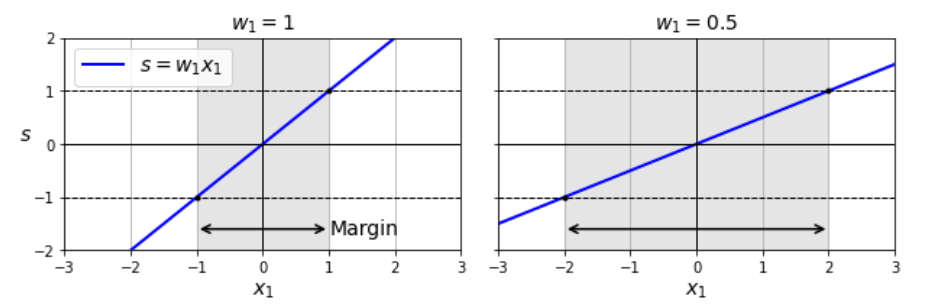

### 하드 마진 선형SVM 분류기의 목적함수와 제약조건

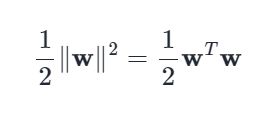


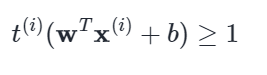

t<sup>(i)</sup>
- i번째 샘플의 클래스(양성/음성)를 가리킨다
- 양성이면 +1, 음성이면 -1
- 결국 위 제약사항은 아래 그래프의 파란부분과 노란부분

> 여기서 >= 1 인 이유는 마진을 적어도 1보다는 크게 하겠다는 의미

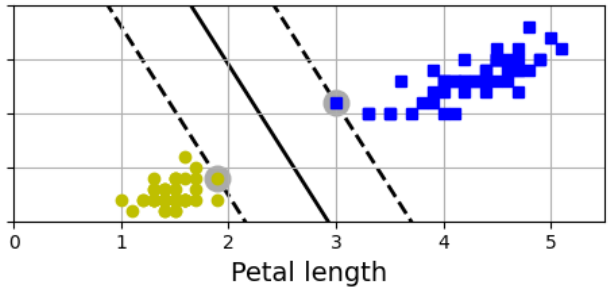

목적함수가 갑자기 왜 저렇게 나왔는지 이해가 안되서 유도를 잠깐 해보면... (출처: https://skyil.tistory.com/150)

X<sub>+</sub> = X<sub>-</sub> + λW : plus plane에서 minus plane은 평행이동

W<sup>T</sup>X<sup>+</sup> + b = 1 : plus plane

W<sup>T</sup>X<sup>+</sup> + b = -1 : minus plane

위 관계를 기반으로

W<sup>T</sup>(X<sup>-</sup>+ λW) + b = 1

W<sup>T</sup>X<sup>-</sup> + b + λW<sup>T</sup>W = 1

-1 + λW<sup>T</sup>W = 1

λ = 2 / W<sup>T</sup>W

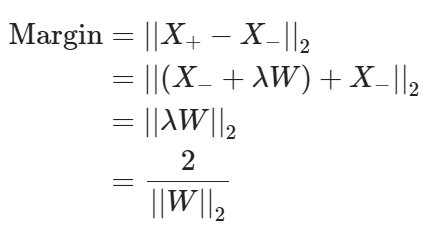

SVM은 마진을 최대하는 것이 목적인데.. 역수를 취하면 아래 식처럼 최소화하는 것이 목적인것과 같다. 계산 용이를 위해 제곱을 한번 함

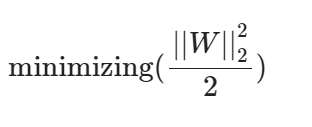

Quadratic Programming(QP)
- 목적식이 2차방정식이고, 제약식이 선형인 문제를 QP라고 함
- QP는 Convex optimization임..
- Convex optimization은 최대값이나 최소값 1개가 존재
- QP는 푸는 방법이 이미 존재. 예) 라그랑지 승수

### 소프트 마진 분류기 목적 함수와 제약사항

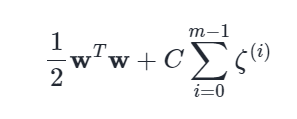

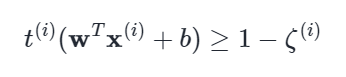

ζ<sup>(i)</sup> : 슬랙변수, i번째 샘플이 얼마나 마진을 위반할지 정함

두 항의 상충된 목표

### SVM 훈련1

힌지 손실 (hinge loss) / 제곱 힌지 손실 (squred hinge loss)

그림 5-13. 힌지 손실(왼쪽)과 제곱 힌지 손실(오른쪽)

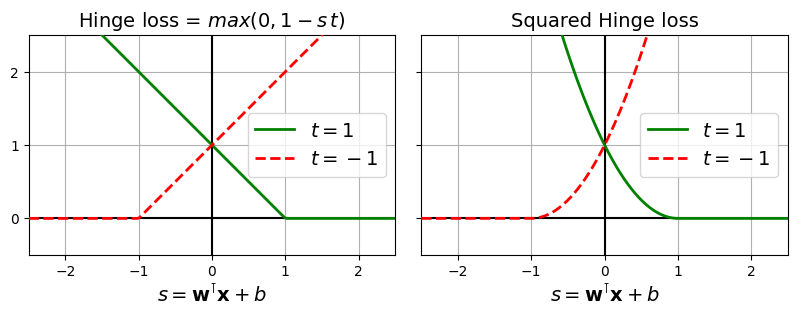

In [ ]:
# 추가 코드 - 이 셀은 그림 5-13을 생성하고 저장합니다.

s = np.linspace(-2.5, 2.5, 200)
hinge_pos = np.where(1 - s < 0, 0, 1 - s)  # max(0, 1 - s)
hinge_neg = np.where(1 + s < 0, 0, 1 + s)  # max(0, 1 + s)

titles = (r"Hinge loss = $max(0, 1 - s\,t)$", "Squared Hinge loss")

fix, axs = plt.subplots(1, 2, sharey=True, figsize=(8.2, 3))

for ax, loss_pos, loss_neg, title in zip(
        axs, (hinge_pos, hinge_pos ** 2), (hinge_neg, hinge_neg ** 2), titles):
    ax.plot(s, loss_pos, "g-", linewidth=2, zorder=10, label="$t=1$")
    ax.plot(s, loss_neg, "r--", linewidth=2, zorder=10, label="$t=-1$")
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlabel(r"$s = \mathbf{w}^\intercal \mathbf{x} + b$")
    ax.axis([-2.5, 2.5, -0.5, 2.5])
    ax.legend(loc="center right")
    ax.set_title(title)
    ax.set_yticks(np.arange(0, 2.5, 1))
    ax.set_aspect("equal")

save_fig("hinge_plot")
plt.show()

- 양성 클래스 샘플 (t = 1)
-- s가 1보다 크면 손실 0

- 음성 클래스 샘플 (t = -1)
-- s가 -1보다 작으면 손실 0

- 제곱 힌지 손실이 이상치에 더 민감하게 반응하지만, 이상치가 없으면 더 빨리 수렴함.
- LinearSVC는 제곱힌지 손실을 사용, SGDClassifier는 힌지 손실을 사용

> 힌지손실은 마진 위반이 발생하거나 데이터가 잘못 분류된 경우 손실을 부과하는 함수 \
> 샘플이 마진 외부에 있을 때는 손실이 0이지만, 마진 내부에 있거나 잘못 분류된 경우에는 손실이 발생 \
> SVM은 힌지 손실을 최소화하여 최적의 분류기를 학습

## 5.5. 쌍대 문제

### SVM 훈련2 - 쌍대문제

>  SVM에서 주어진 **원래의 최적화 문제(Primal Problem)**를 변형하여 쌍대 문제로 바꾸면, 더 효율적이거나 해결하기 쉬운 방식으로 SVM을 훈련할 수 있음

목적함수와 제약사항을 Primal Problem이라고 하면, 라그랑지 승수를 이용해서 제약사항 없는 최적화 문제로 변환

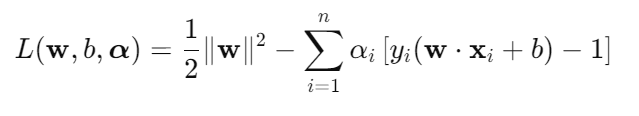

α는 라그랑지승수(제약조건에 포함)

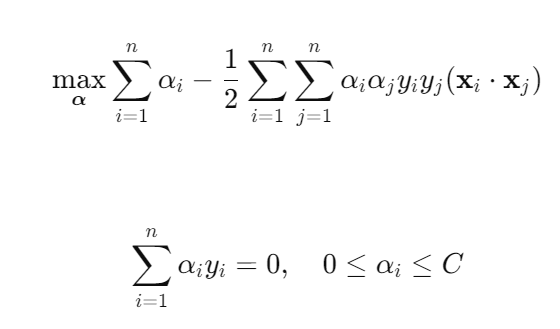

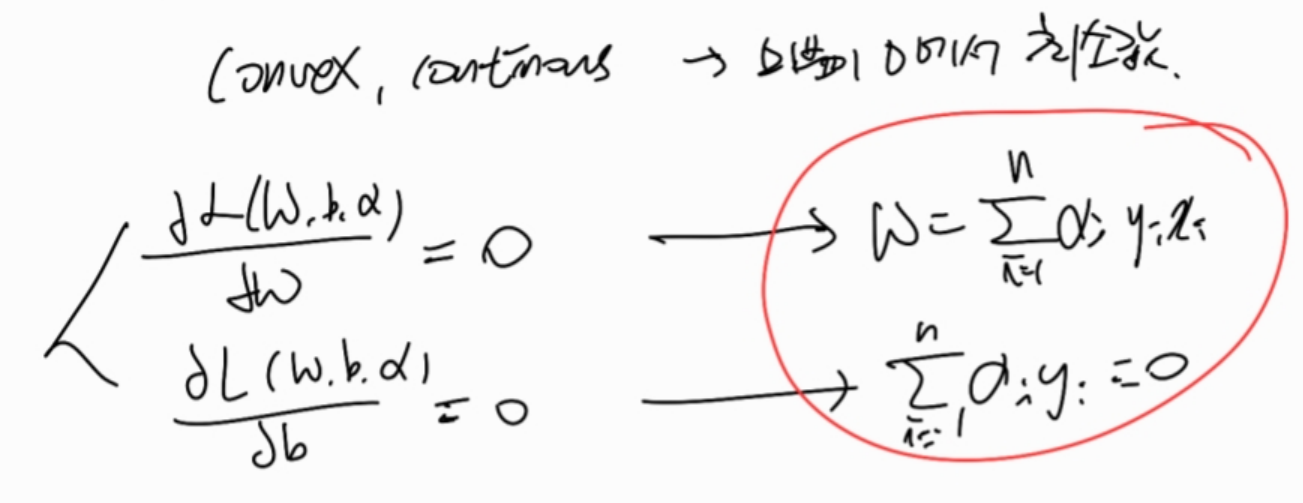

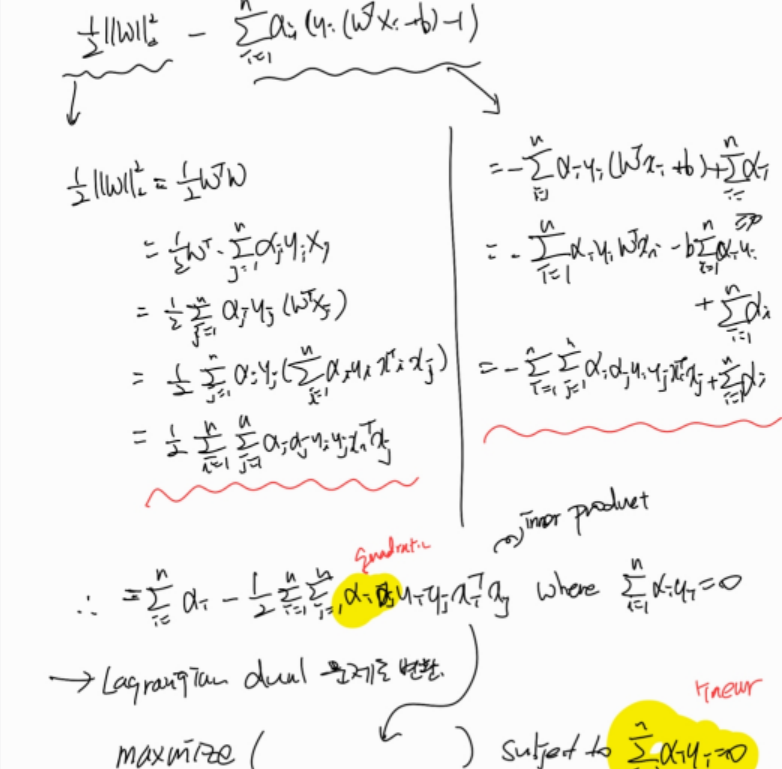

이를 이용해서 W와 b를 구한다

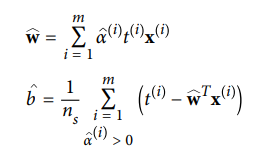

## 5.5.1 커널 SVM

> Primal Problem에서 𝑤는 입력 데이터x와 직접적인 관계를 맺고 있음\
> 즉, 결정 경계는 입력 공간에서 데이터에 대한 선형 결정을 정의. \
> 이 방식은 선형적으로 분리 가능한 데이터에서는 잘 작동하지만, 비선형 데이터에서는 제대로 된 분류가 불가능

> Dual Problem으로 변환하면, 최적화는 더 이상 **
𝑤와 𝑏를 직접적으로 다루지 않고, **라그랑주 승수 𝛼를 통해 데이터 포인트 간의 내적으로 문제를 해결 -> 내적을 커널함수로 변환

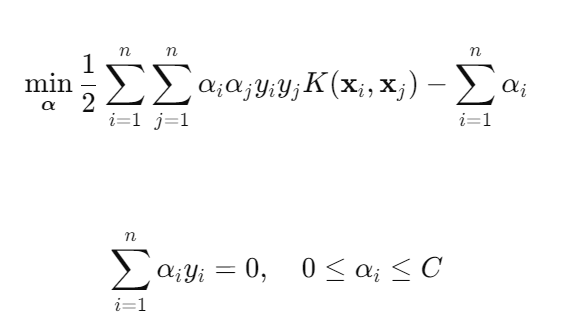

2차원 데이터셋에 2차 다항식 변환을 적용하고 훈련 시킨다고 생각해보자

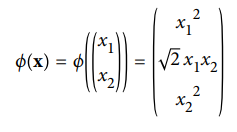

2차원 벡터 a, b에 다항식 매핑을 적용하면 원래 벡터의 dot product의 제곱이됨

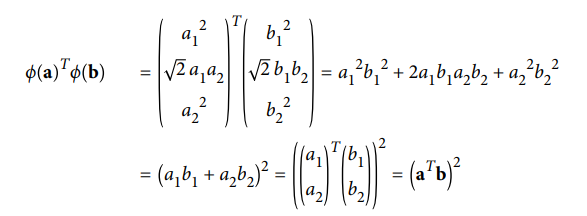

image.png

결국 변환을 몰라도 (샘플을 변환하지 않아도) 된다...dot product 부분을 제곱으로만 바꾸면 된다.

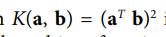

- 2차 다항식 커널
- 변환을 계산하지 않고, (변환식 자체를 모르더라도) ,a,b에 기반하여 dot product 계산이 가능한 함수 : 커널

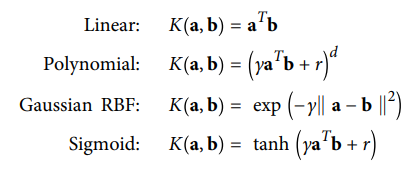

w의 차원이 매우 크서 계산을 못할 때 w를 모른 채 예측할 수 있을가?

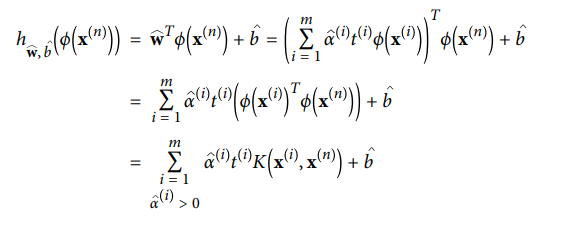

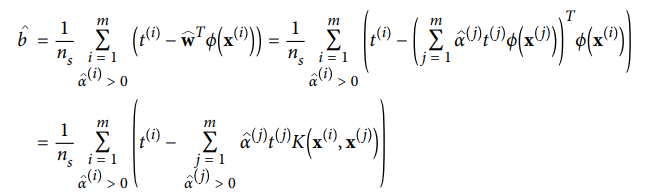